In [2]:
import math
import numpy as np
import tensorflow as tf
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.datasets import cifar10
from skimage.transform import resize
import matplotlib.pyplot as plt
from scipy.linalg import sqrtm
import pickle
from scipy.stats import truncnorm
# modules
from Ops.spectral_normalization import SpectralConv2D, SpectralDense
from Ops.ops import ResnetBlock, ResnetBlockUp, ResnetBlockDown
from Ops.attention import Attention
from Ops.global_sum_pooling import GlobalSumPooling2D
from Ops.conditional_batch_normalization import ConditionalBatchNormalization

import os 
from PIL import Image
import matplotlib.pyplot as plt
import random
import seaborn as sn
import pandas as pd

In [2]:
# scale an array of images to a new size
def scale_images(images, new_shape):
    images_list = list()
    for image in images:
        # resize with nearest neighbor interpolation
        new_image = resize(image, new_shape, 0)
        # store
        images_list.append(new_image)
    return np.asarray(images_list)

In [3]:
# assumes images have any shape and pixels in [0,255]
def calculate_inception_score(images, n_split=10, eps=1E-16):
    # load inception v3 model
    model = InceptionV3()
    # enumerate splits of images/predictions
    scores = list()
    n_part = math.floor(images.shape[0] / n_split)
    for i in range(n_split):
        # retrieve images
        ix_start, ix_end = i * n_part, (i+1) * n_part
        subset = images[ix_start:ix_end]
        # convert from uint8 to float32
        subset = subset.astype('float32')
        # scale images to the required size
        subset = scale_images(subset, (299,299,3))
        # pre-process images, scale to [-1,1]
        subset = preprocess_input(subset)
        # predict p(y|x)
        p_yx = model.predict(subset)
        # calculate p(y)
        p_y = np.expand_dims(p_yx.mean(axis=0), 0)
        # calculate KL divergence using log probabilities
        kl_d = p_yx * (np.log(p_yx + eps) - np.log(p_y + eps))
        # sum over classes
        sum_kl_d = kl_d.sum(axis=1)
        # average over images
        avg_kl_d = np.mean(sum_kl_d)
        # undo the log
        is_score = np.exp(avg_kl_d)
        # store
        scores.append(is_score)
    # average across images
    is_avg, is_std = np.mean(scores), np.std(scores)
    return is_avg, is_std

In [4]:
# calculate frechet inception distance
def calculate_fid(images1, images2):
    model = InceptionV3(include_top=False, pooling='avg', input_shape=(299,299,3))
    # convert integer to floating point values
    images1 = images1.astype('float32')
    images2 = images2.astype('float32')
    # resize images
    images1 = scale_images(images1, (299,299,3))
    images2 = scale_images(images2, (299,299,3))
    # pre-process images
    images1 = preprocess_input(images1)
    images2 = preprocess_input(images2)
    # calculate activations
    act1 = model.predict(images1)
    act2 = model.predict(images2)
    # calculate mean and covariance statistics
    mu1, sigma1 = act1.mean(axis=0), np.cov(act1, rowvar=False)
    mu2, sigma2 = act2.mean(axis=0), np.cov(act2, rowvar=False)
    # calculate sum squared difference between means
    ssdiff = np.sum((mu1 - mu2)**2.0)
    # calculate sqrt of product between cov
    covmean = sqrtm(sigma1.dot(sigma2))
    # check and correct imaginary numbers from sqrt
    if np.iscomplexobj(covmean):
        covmean = covmean.real
    # calculate score
    fid = ssdiff + np.trace(sigma1 + sigma2 - 2.0 * covmean)
    return fid

In [5]:
# generate points in latent space as input for the generator
def generate_latent_points(n_samples, latent_dim=100, n_classes=10, bigGAN=False):
    if not bigGAN:
        # generate points in the latent space
        z_input = np.random.randn(n_samples * latent_dim)
        # reshape into a batch of inputs for the network
        z_input = z_input.reshape(n_samples, latent_dim)
    else:
        z_input = truncnorm.rvs(-2, 2, size=(n_samples, latent_dim), random_state=None).astype(np.float32)
        z_input = z_input * 2.0 # 2.0 is truncation value
    # generate labels
    labels = np.random.randint(0, n_classes, n_samples)
    return [z_input, labels]

In [6]:
def calc_is_for_bigGAN(generator, n_split=10, eps=1E-16, custom_objects=None):
    generator = tf.keras.models.load_model(generator, custom_objects=custom_objects)
    #generate latent points for 50k images
    [z_input, labels] = generate_latent_points(50000, latent_dim=128, bigGAN=True)
    images = generator.predict([z_input, labels])
    images = (images*127.5) + 127.5
    print('generated ', images.shape)
    #calculate IS score
    is_avg, is_std = calculate_inception_score(images)
    print('score', is_avg, is_std)

In [7]:
def calc_fid_for_bigGAN(generator, custom_objects=None):
    generator = tf.keras.models.load_model(generator, custom_objects=custom_objects)
    #generate latent points for 50k images
    [z_input, labels] = generate_latent_points(10000, latent_dim=128, bigGAN=True)
    fake_images = generator.predict([z_input, labels])
    fake_images = (fake_images*127.5) + 127.5
    print('generated ', fake_images.shape)
    (real_images, _), (_, _) = cifar10.load_data()
    np.random.shuffle(real_images)
    real_images = real_images[:10000]
    #calculate FID score
    fid = calculate_fid(real_images, fake_images)
    print('FID', fid)

# AC-BigGAN_CIFAR10_1
<p>Batch Size : 64 </p>
<p>D steps per G step = 1</p>

In [8]:
#measure IS
custom_objects={'SpectralDense': SpectralDense, 'SpectralConv2D': SpectralConv2D}
generator = './history/bigacgan/bigacgan-cifar10-1/training_checkpoints/generator-e200.h5'
calc_is_for_bigGAN(generator, custom_objects=custom_objects)

generated  (50000, 32, 32, 3)
score 7.350445 0.07936605


In [16]:
#measure FID
custom_objects={'SpectralDense': SpectralDense, 'SpectralConv2D': SpectralConv2D}
generator = './history/bigacgan/bigacgan-cifar10-1/training_checkpoints/generator-e200.h5'
calc_fid_for_bigGAN(generator, custom_objects=custom_objects)

generated  (10000, 32, 32, 3)
FID 28.979871542951834


In [14]:
#measure accuracy on CIFAR10 test data
custom_objects={'SpectralDense': SpectralDense, 'SpectralConv2D': SpectralConv2D}
discriminator = './history/bigacgan/bigacgan-cifar10-1/training_checkpoints/discriminator-e200.h5'
discriminator = tf.keras.models.load_model(discriminator, custom_objects=custom_objects)
(_, _), (testX, testY) = cifar10.load_data()
testX = testX.astype('float32')
testX = (testX - 127.5) / 127.5
_eval = discriminator.evaluate(testX, testY, batch_size=64)

157/157 [==============================] - 1s 9ms/step - loss: -4.3778 - out_fake_loss: -5.2616 - out_aux_loss: 0.8838 - out_fake_accuracy: 0.1352 - out_aux_out_aux_sparse_categorical_accuracy: 0.7628


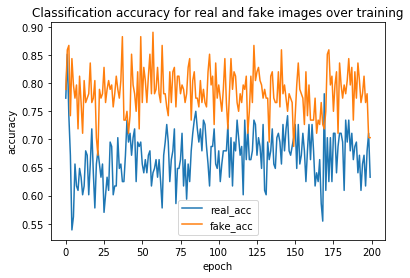

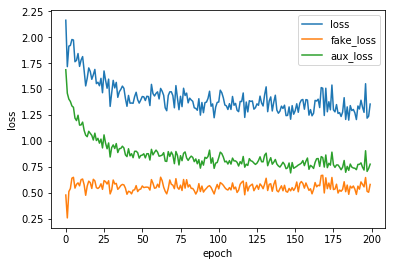

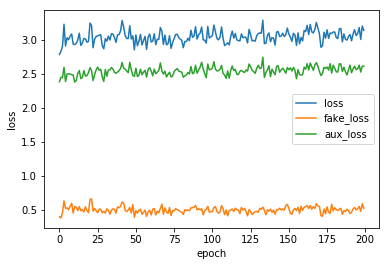

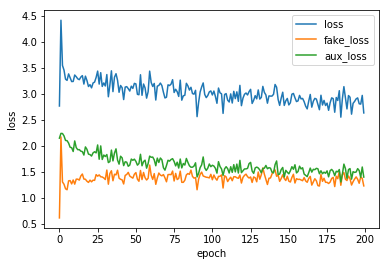

In [7]:
d_real_losses = pickle.load(open('history/bigacgan/bigacgan-cifar10-2/evaluation/d_real_losses.p', 'rb'))
d_fake_losses = pickle.load(open('history/bigacgan/bigacgan-cifar10-2/evaluation/d_fake_losses.p', 'rb'))
g_losses = pickle.load(open('history/bigacgan/bigacgan-cifar10-2/evaluation/g_losses.p', 'rb'))

real_out_class = [x['out_aux_sparse_categorical_accuracy'] for x in d_real_losses]
fake_out_class = [x['out_aux_sparse_categorical_accuracy'] for x in d_fake_losses]
real_out = [x['out_fake_accuracy'] for x in d_real_losses]
fake_out = [x['out_fake_accuracy'] for x in d_fake_losses]

#plt.plot(range(0,len(real_out_class)), real_out_class, label='real_class_acc')
#plt.plot(range(0,len(fake_out_class)), fake_out_class, label='fake_class_acc')
plt.plot(range(0,len(real_out)), real_out, label='real_acc')
plt.plot(range(0,len(fake_out)), fake_out, label='fake_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Classification accuracy for real and fake images over training')
plt.legend()
plt.show()

real_loss = [x['loss'] for x in d_real_losses]
real_fake_loss = [x['out_fake_loss'] for x in d_real_losses]
real_aux_loss = [x['out_aux_loss'] for x in d_real_losses]
plt.plot(range(0,len(real_loss)), real_loss, label='loss')
plt.plot(range(0,len(real_fake_loss)), real_fake_loss, label='fake_loss')
plt.plot(range(0,len(real_aux_loss)), real_aux_loss, label='aux_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()


fake_loss = [x['loss'] for x in d_fake_losses]
fake_fake_loss = [x['out_fake_loss'] for x in d_fake_losses]
fake_aux_loss = [x['out_aux_loss'] for x in d_fake_losses]
plt.plot(range(0,len(fake_loss)), fake_loss, label='loss')
plt.plot(range(0,len(fake_fake_loss)), fake_fake_loss, label='fake_loss')
plt.plot(range(0,len(fake_aux_loss)), fake_aux_loss, label='aux_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

g_loss = [x['loss'] for x in g_losses]
g_fake_loss = [x['discriminator_loss'] for x in g_losses]
g_aux_loss = [x['discriminator_1_loss'] for x in g_losses]
plt.plot(range(0,len(g_loss)), g_loss, label='loss')
plt.plot(range(0,len(g_fake_loss)), g_fake_loss, label='fake_loss')
plt.plot(range(0,len(g_aux_loss)), g_aux_loss, label='aux_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# AC-BigGAN_CIFAR10_6
<p>Batch Size : 64 </p>
<p>D steps per G step = 1</p>
Fixed real labels for fake images "mistake"

In [ ]:
#measure IS
custom_objects={'SpectralDense': SpectralDense, 'SpectralConv2D': SpectralConv2D}
generator = './history/bigacgan/bigacgan-cifar10-6/training_checkpoints/generator-e200.h5'
calc_is_for_bigGAN(generator, custom_objects=custom_objects)

In [15]:
#measure FID
custom_objects={'SpectralDense': SpectralDense, 'SpectralConv2D': SpectralConv2D}
generator = './history/bigacgan/bigacgan-cifar10-6/training_checkpoints/generator-e200.h5'
calc_fid_for_bigGAN(generator, custom_objects=custom_objects)

generated  (10000, 32, 32, 3)
FID 34.625384761295365


In [13]:
#measure accuracy on CIFAR10 test data
custom_objects={'SpectralDense': SpectralDense, 'SpectralConv2D': SpectralConv2D}
discriminator = './history/bigacgan/bigacgan-cifar10-6/training_checkpoints/discriminator-e200.h5'
discriminator = tf.keras.models.load_model(discriminator, custom_objects=custom_objects)
(_, _), (testX, testY) = cifar10.load_data()
testX = testX.astype('float32')
testX = (testX - 127.5) / 127.5
_eval = discriminator.evaluate(testX, testY, batch_size=64)

157/157 [==============================] - 1s 9ms/step - loss: -4.5638 - out_fake_loss: -5.2855 - out_aux_loss: 0.7217 - out_fake_accuracy: 0.1149 - out_aux_out_aux_sparse_categorical_accuracy: 0.7867


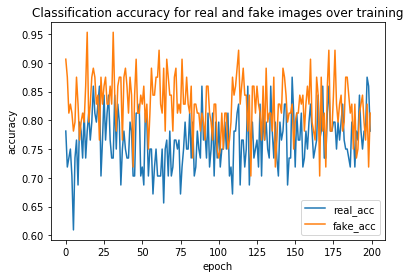

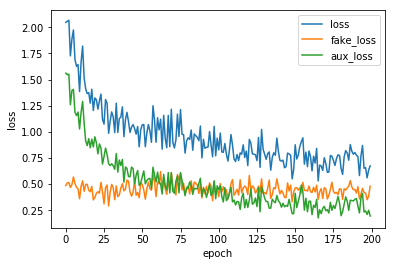

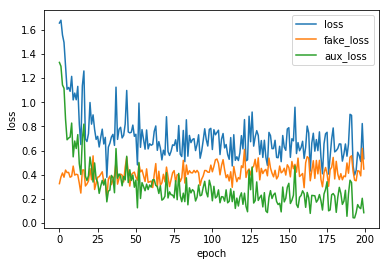

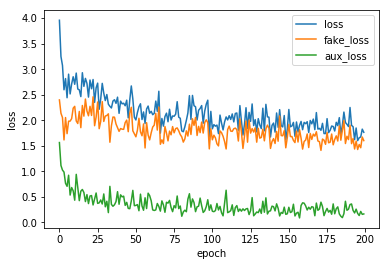

In [10]:
d_real_losses = pickle.load(open('history/bigacgan/bigacgan-cifar10-6/evaluation/d_real_losses.p', 'rb'))
d_fake_losses = pickle.load(open('history/bigacgan/bigacgan-cifar10-6/evaluation/d_fake_losses.p', 'rb'))
g_losses = pickle.load(open('history/bigacgan/bigacgan-cifar10-6/evaluation/g_losses.p', 'rb'))

real_out_class = [x['out_aux_sparse_categorical_accuracy'] for x in d_real_losses]
fake_out_class = [x['out_aux_sparse_categorical_accuracy'] for x in d_fake_losses]



real_out = [x['out_fake_accuracy'] for x in d_real_losses]
fake_out = [x['out_fake_accuracy'] for x in d_fake_losses]

#plt.plot(range(0,len(real_out_class)), real_out_class, label='real_class_acc')
#plt.plot(range(0,len(fake_out_class)), fake_out_class, label='fake_class_acc')
plt.plot(range(0,len(real_out)), real_out, label='real_acc')
plt.plot(range(0,len(fake_out)), fake_out, label='fake_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Classification accuracy for real and fake images over training')
plt.legend()
plt.show()

real_loss = [x['loss'] for x in d_real_losses]
real_fake_loss = [x['out_fake_loss'] for x in d_real_losses]
real_aux_loss = [x['out_aux_loss'] for x in d_real_losses]
plt.plot(range(0,len(real_loss)), real_loss, label='loss')
plt.plot(range(0,len(real_fake_loss)), real_fake_loss, label='fake_loss')
plt.plot(range(0,len(real_aux_loss)), real_aux_loss, label='aux_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()


fake_loss = [x['loss'] for x in d_fake_losses]
fake_fake_loss = [x['out_fake_loss'] for x in d_fake_losses]
fake_aux_loss = [x['out_aux_loss'] for x in d_fake_losses]
plt.plot(range(0,len(fake_loss)), fake_loss, label='loss')
plt.plot(range(0,len(fake_fake_loss)), fake_fake_loss, label='fake_loss')
plt.plot(range(0,len(fake_aux_loss)), fake_aux_loss, label='aux_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

g_loss = [x['loss'] for x in g_losses]
g_fake_loss = [x['discriminator_loss'] for x in g_losses]
g_aux_loss = [x['discriminator_1_loss'] for x in g_losses]
plt.plot(range(0,len(g_loss)), g_loss, label='loss')
plt.plot(range(0,len(g_fake_loss)), g_fake_loss, label='fake_loss')
plt.plot(range(0,len(g_aux_loss)), g_aux_loss, label='aux_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

# AC-BigGAN_CIFAR10_8
<p>Batch Size : 64 </p>
<p>D steps per G step = 1</p>
Fixed real labels for fake images "mistake" and empowered generator with 50% fmaps increase to 192

In [11]:
#measure IS
custom_objects={'SpectralDense': SpectralDense, 'SpectralConv2D': SpectralConv2D}
generator = './history/bigacgan/bigacgan-cifar10-8/training_checkpoints/generator-e200.h5'
calc_is_for_bigGAN(generator, custom_objects=custom_objects)

generated  (50000, 32, 32, 3)
score 6.9949026 0.059043147


In [12]:
#measure FID
custom_objects={'SpectralDense': SpectralDense, 'SpectralConv2D': SpectralConv2D}
generator = './history/bigacgan/bigacgan-cifar10-8/training_checkpoints/generator-e200.h5'
calc_fid_for_bigGAN(generator, custom_objects=custom_objects)

generated  (10000, 32, 32, 3)
FID 31.558468565029006


In [10]:
#measure accuracy on CIFAR10 test data
custom_objects={'SpectralDense': SpectralDense, 'SpectralConv2D': SpectralConv2D}
discriminator = './history/bigacgan/bigacgan-cifar10-8/training_checkpoints/discriminator-e200.h5'
discriminator = tf.keras.models.load_model(discriminator, custom_objects=custom_objects)
(_, _), (testX, testY) = cifar10.load_data()
testX = testX.astype('float32')
testX = (testX - 127.5) / 127.5
_eval = discriminator.evaluate(testX, testY, batch_size=64)

157/157 [==============================] - 2s 10ms/step - loss: -4.0179 - out_fake_loss: -4.7737 - out_aux_loss: 0.7557 - out_fake_accuracy: 0.1081 - out_aux_out_aux_sparse_categorical_accuracy: 0.7829


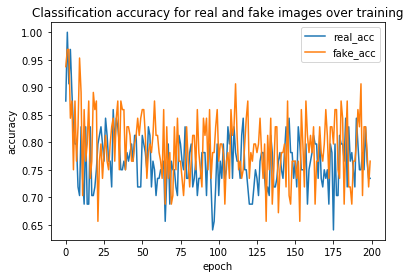

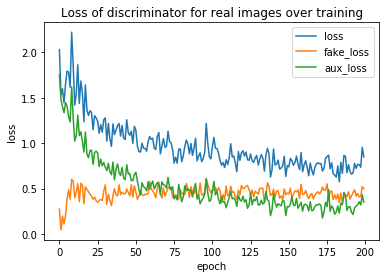

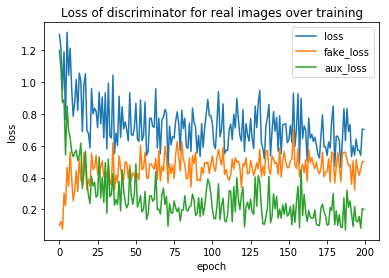

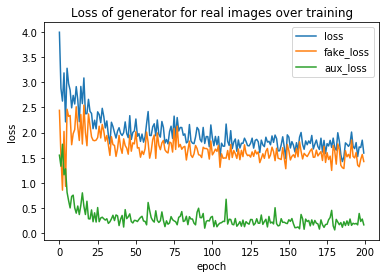

In [8]:
d_real_losses = pickle.load(open('history/bigacgan/bigacgan-cifar10-8/evaluation/d_real_losses.p', 'rb'))
d_fake_losses = pickle.load(open('history/bigacgan/bigacgan-cifar10-8/evaluation/d_fake_losses.p', 'rb'))
g_losses = pickle.load(open('history/bigacgan/bigacgan-cifar10-8/evaluation/g_losses.p', 'rb'))

real_out_class = [x['out_aux_sparse_categorical_accuracy'] for x in d_real_losses]
fake_out_class = [x['out_aux_sparse_categorical_accuracy'] for x in d_fake_losses]



real_out = [x['out_fake_accuracy'] for x in d_real_losses]
fake_out = [x['out_fake_accuracy'] for x in d_fake_losses]

#plt.plot(range(0,len(real_out_class)), real_out_class, label='real_class_acc')
#plt.plot(range(0,len(fake_out_class)), fake_out_class, label='fake_class_acc')
plt.plot(range(0,len(real_out)), real_out, label='real_acc')
plt.plot(range(0,len(fake_out)), fake_out, label='fake_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Classification accuracy for real and fake images over training')
plt.legend()
plt.show()

real_loss = [x['loss'] for x in d_real_losses]
real_fake_loss = [x['out_fake_loss'] for x in d_real_losses]
real_aux_loss = [x['out_aux_loss'] for x in d_real_losses]
plt.plot(range(0,len(real_loss)), real_loss, label='loss')
plt.plot(range(0,len(real_fake_loss)), real_fake_loss, label='fake_loss')
plt.plot(range(0,len(real_aux_loss)), real_aux_loss, label='aux_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss of discriminator for real images over training')
plt.legend()
plt.show()


fake_loss = [x['loss'] for x in d_fake_losses]
fake_fake_loss = [x['out_fake_loss'] for x in d_fake_losses]
fake_aux_loss = [x['out_aux_loss'] for x in d_fake_losses]
plt.plot(range(0,len(fake_loss)), fake_loss, label='loss')
plt.plot(range(0,len(fake_fake_loss)), fake_fake_loss, label='fake_loss')
plt.plot(range(0,len(fake_aux_loss)), fake_aux_loss, label='aux_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss of discriminator for fake images over training')
plt.legend()
plt.show()

g_loss = [x['loss'] for x in g_losses]
g_fake_loss = [x['discriminator_loss'] for x in g_losses]
g_aux_loss = [x['discriminator_1_loss'] for x in g_losses]
plt.plot(range(0,len(g_loss)), g_loss, label='loss')
plt.plot(range(0,len(g_fake_loss)), g_fake_loss, label='fake_loss')
plt.plot(range(0,len(g_aux_loss)), g_aux_loss, label='aux_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss of generator for real images over training')
plt.legend()
plt.show()

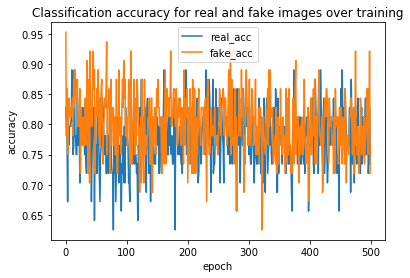

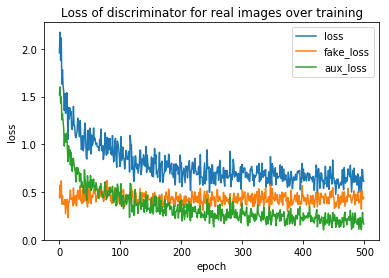

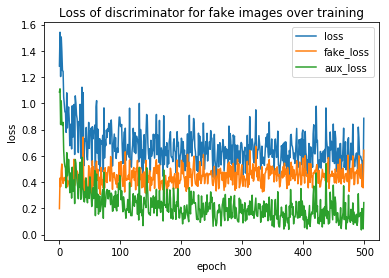

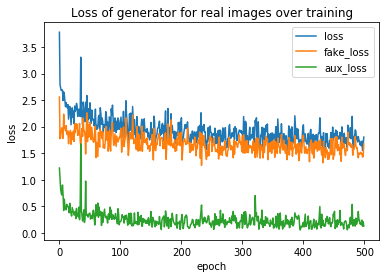

In [3]:
d_real_losses = pickle.load(open('history/bigacgan/bigacgan-cifar10-7/evaluation/d_real_losses.p', 'rb'))
d_fake_losses = pickle.load(open('history/bigacgan/bigacgan-cifar10-7/evaluation/d_fake_losses.p', 'rb'))
g_losses = pickle.load(open('history/bigacgan/bigacgan-cifar10-7/evaluation/g_losses.p', 'rb'))

real_out_class = [x['out_aux_sparse_categorical_accuracy'] for x in d_real_losses]
fake_out_class = [x['out_aux_sparse_categorical_accuracy'] for x in d_fake_losses]



real_out = [x['out_fake_accuracy'] for x in d_real_losses]
fake_out = [x['out_fake_accuracy'] for x in d_fake_losses]

#plt.plot(range(0,len(real_out_class)), real_out_class, label='real_class_acc')
#plt.plot(range(0,len(fake_out_class)), fake_out_class, label='fake_class_acc')
plt.plot(range(0,len(real_out)), real_out, label='real_acc')
plt.plot(range(0,len(fake_out)), fake_out, label='fake_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Classification accuracy for real and fake images over training')
plt.legend()
plt.show()

real_loss = [x['loss'] for x in d_real_losses]
real_fake_loss = [x['out_fake_loss'] for x in d_real_losses]
real_aux_loss = [x['out_aux_loss'] for x in d_real_losses]
plt.plot(range(0,len(real_loss)), real_loss, label='loss')
plt.plot(range(0,len(real_fake_loss)), real_fake_loss, label='fake_loss')
plt.plot(range(0,len(real_aux_loss)), real_aux_loss, label='aux_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss of discriminator for real images over training')
plt.legend()
plt.show()


fake_loss = [x['loss'] for x in d_fake_losses]
fake_fake_loss = [x['out_fake_loss'] for x in d_fake_losses]
fake_aux_loss = [x['out_aux_loss'] for x in d_fake_losses]
plt.plot(range(0,len(fake_loss)), fake_loss, label='loss')
plt.plot(range(0,len(fake_fake_loss)), fake_fake_loss, label='fake_loss')
plt.plot(range(0,len(fake_aux_loss)), fake_aux_loss, label='aux_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss of discriminator for fake images over training')
plt.legend()
plt.show()

g_loss = [x['loss'] for x in g_losses]
g_fake_loss = [x['discriminator_loss'] for x in g_losses]
g_aux_loss = [x['discriminator_1_loss'] for x in g_losses]
plt.plot(range(0,len(g_loss)), g_loss, label='loss')
plt.plot(range(0,len(g_fake_loss)), g_fake_loss, label='fake_loss')
plt.plot(range(0,len(g_aux_loss)), g_aux_loss, label='aux_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss of generator for real images over training')
plt.legend()
plt.show()

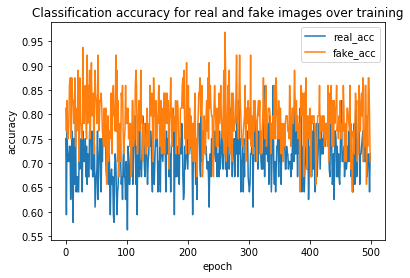

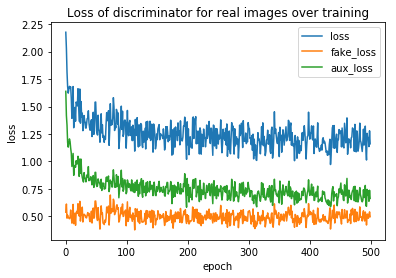

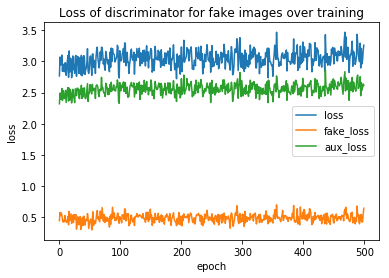

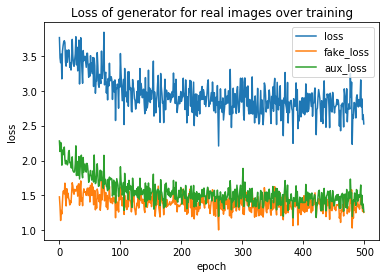

In [5]:
d_real_losses = pickle.load(open('history/bigacgan/bigacgan-cifar10-3/evaluation/d_real_losses.p', 'rb'))
d_fake_losses = pickle.load(open('history/bigacgan/bigacgan-cifar10-3/evaluation/d_fake_losses.p', 'rb'))
g_losses = pickle.load(open('history/bigacgan/bigacgan-cifar10-3/evaluation/g_losses.p', 'rb'))

real_out_class = [x['out_aux_sparse_categorical_accuracy'] for x in d_real_losses]
fake_out_class = [x['out_aux_sparse_categorical_accuracy'] for x in d_fake_losses]



real_out = [x['out_fake_accuracy'] for x in d_real_losses]
fake_out = [x['out_fake_accuracy'] for x in d_fake_losses]

#plt.plot(range(0,len(real_out_class)), real_out_class, label='real_class_acc')
#plt.plot(range(0,len(fake_out_class)), fake_out_class, label='fake_class_acc')
plt.plot(range(0,len(real_out)), real_out, label='real_acc')
plt.plot(range(0,len(fake_out)), fake_out, label='fake_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Classification accuracy for real and fake images over training')
plt.legend()
plt.show()

real_loss = [x['loss'] for x in d_real_losses]
real_fake_loss = [x['out_fake_loss'] for x in d_real_losses]
real_aux_loss = [x['out_aux_loss'] for x in d_real_losses]
plt.plot(range(0,len(real_loss)), real_loss, label='loss')
plt.plot(range(0,len(real_fake_loss)), real_fake_loss, label='fake_loss')
plt.plot(range(0,len(real_aux_loss)), real_aux_loss, label='aux_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss of discriminator for real images over training')
plt.legend()
plt.show()


fake_loss = [x['loss'] for x in d_fake_losses]
fake_fake_loss = [x['out_fake_loss'] for x in d_fake_losses]
fake_aux_loss = [x['out_aux_loss'] for x in d_fake_losses]
plt.plot(range(0,len(fake_loss)), fake_loss, label='loss')
plt.plot(range(0,len(fake_fake_loss)), fake_fake_loss, label='fake_loss')
plt.plot(range(0,len(fake_aux_loss)), fake_aux_loss, label='aux_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss of discriminator for fake images over training')
plt.legend()
plt.show()

g_loss = [x['loss'] for x in g_losses]
g_fake_loss = [x['discriminator_loss'] for x in g_losses]
g_aux_loss = [x['discriminator_1_loss'] for x in g_losses]
plt.plot(range(0,len(g_loss)), g_loss, label='loss')
plt.plot(range(0,len(g_fake_loss)), g_fake_loss, label='fake_loss')
plt.plot(range(0,len(g_aux_loss)), g_aux_loss, label='aux_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss of generator for real images over training')
plt.legend()
plt.show()